In [2]:
# coding: utf-8
import numpy as np
import pandas as pd
# наше всё

pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)
#настройки, с которыми лучше


In [3]:
# unixtime to time
def fr_unixtime(ts):
    from datetime import datetime
    return datetime.utcfromtimestamp(int(ts)).strftime('%Y-%m-%d %H:%M:%S')

In [4]:
# working with pgn
def get_pgn(text):
    from pgn_parser import pgn, parser
    game = parser.parse(text, actions=pgn.Actions())
    
    try:
        score=game.tag_pairs['Result']
    except:
        score='Unknown'  
    try:
        date=game.tag_pairs['Date']
    except:
        date='Unknown'
    try:
        time=game.tag_pairs['UTCTime']
    except:
        time='Unknown'
    try:
        eco=game.tag_pairs['ECO']
    except:
        eco='Unknown'
    try:
        ecourl=game.tag_pairs['ECOUrl']
    except:
        ecourl='Unknown'
    return {'score':score, 
            'date': date, 
            'time':time, 
            'ECO':eco, 
            'ECO_url':ecourl}

In [161]:
# reauests hits

#response = requests.get('https://api.chess.com/pub/player/erik/games/2009/10')
#response = requests.get('https://api.chess.com/pub/player/rosolimo/stats')
#response = requests.get('https://api.chess.com/pub/player/rosolimo/games/2019/07')
#response = requests.get('https://api.chess.com/pub/country/RU/players')


200


55796

In [7]:
# get player games in month with preparation
def get_pl_stat(player, year, month):
    # api part
    import requests
    response = requests.get('https://api.chess.com/pub/player/'+player+'/games/'+year+'/'+month)
    # print(response.status_code)
    
    st=response.text
    file = open('chess_curr.json','w') 
    file.write(st)
    file.close()
    
    # chess result dictionary
    res_dict={
    'win': 1.0,
    'checkmated': 0.0,
    'agreed': 0.5,
    'repetition': 0.5,
    'timeout': 0.0,
    'resigned': 0.0,
    'stalemate': 0.5,
    'lose': 0.0,
    'insufficient': 0.5,
    '50move': 0.5,
    'abandoned': 0.0,
    'kingofthehill': 0.5,
    'threecheck': 0.5,
    'timevsinsufficient': 0.5,
    'bughousepartnerlose': 0.0
    }
    
    total_info=pd.read_json('chess_curr.json')
    
    # number of games
    num=len(total_info)
    
    game_stat=pd.DataFrame()
    for i in range(num):
        b=pd.io.json.json_normalize(total_info.values[i])
        b=b[['rules', 'time_class', 'time_control', 'rated',
            'white.@id', 'white.rating', 'white.result', 'white.username',
             'black.@id', 'black.rating', 'black.result', 'black.username',
             'end_time', 'pgn', 
             'url'
       ]]
        b['white.score']=b['white.result'].map(res_dict)
        b['black.score']=b['black.result'].map(res_dict)
        game_stat=pd.concat([game_stat, b])
    game_stat['pgn']=game_stat['pgn'].apply(get_pgn)
    game_stat['result']=game_stat['pgn'].apply(lambda x: x['score'])
    game_stat['date']=game_stat['pgn'].apply(lambda x: x['date'])
    game_stat['time']=game_stat['pgn'].apply(lambda x: x['time'])
    game_stat['eco']=game_stat['pgn'].apply(lambda x: x['ECO'])
    game_stat['eco_url']=game_stat['pgn'].apply(lambda x: x['ECO_url'])
    
    game_stat.columns=['rules', 'time_class', 'time_control', 'rated', 'white_url',
       'white.rating', 'white.result', 'white.username', 'black_url',
       'black.rating', 'black.result', 'black.username', 'end_time', 'pgn', 'game_url',
       'white.score', 'black.score', 'result', 'date', 'time', 'eco',
       'eco_url']
    game_stat=game_stat[[
        'rules', 'time_class', 'time_control', 'rated', 
        'result', 'date', 'time', 
        'white.username', 'black.username',
        'white.rating', 'black.rating', 
        'white.result', 'black.result', 
        'white.score', 'black.score', 
        'eco', 'eco_url', 
        'game_url', 'white_url', 'black_url'

    ]]
    
    return game_stat

In [11]:
def get_full_player_stat(player):
    year_lst=['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
    #year_lst=['2018', '2019']
    month_lst=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    full_player_stat=pd.DataFrame()
    for year in year_lst:
        for month in month_lst:
            try:
                tb=get_pl_stat(player, year, month)
            except:
                tb=pd.DataFrame()
            full_player_stat=pd.concat([full_player_stat, tb])
    return full_player_stat

In [12]:
%%time
df=get_full_player_stat('rosolimo')

CPU times: user 14min 55s, sys: 2.02 s, total: 14min 57s
Wall time: 20min 54s


In [81]:
len(df)

11430

In [9]:
#game_stat=get_pl_stat('rosolimo', '2017', '12')

In [111]:
df.sample(15)

,rules,time_class,time_control,rated,result,date,time,white.username,black.username,white.rating,black.rating,white.result,black.result,white.score,black.score,eco,eco_url,game_url,white_url,black_url,game,period
0,chess,blitz,180+2,True,1-0,2017-08-29,07:06:37,haakon0603,Rosolimo,1507,1540,win,resigned,1.0,0.0,D02,https://www.chess.com/openings/D02-Queens-Pawn-Opening-Symmetrical-Variation,https://www.chess.com/live/game/2283350870,https://api.chess.com/pub/player/haakon0603,https://api.chess.com/pub/player/rosolimo,1,2017-8
0,chess,blitz,300,True,1-0,2016-01-27,10:22:14,xboy_inmotion,Rosolimo,1673,1639,win,resigned,1.0,0.0,B18,https://www.chess.com/openings/B18-Caro-Kann-Defense-Classical-Variation-5.Ng3-Bg6-6.Nf3-Nd7-7.Bd3,https://www.chess.com/live/game/1438537920,https://api.chess.com/pub/player/xboy_inmotion,https://api.chess.com/pub/player/rosolimo,1,2016-1
0,chess,blitz,300,True,0-1,2014-08-03,12:08:02,Rosolimo,hrac,1499,1469,resigned,win,0.0,1.0,D37,https://www.chess.com/openings/D37-Queens-Gambit-Declined-Three-Knights-Variation-4...Be7,https://www.chess.com/live/game/877318532,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/hrac,1,2014-8
0,chess,blitz,180+2,True,0-1,2019-03-29,11:42:52,Rosolimo,korolady,1599,1580,resigned,win,0.0,1.0,D37,https://www.chess.com/openings/D37-Queens-Gambit-Declined-Three-Knights-Variation-4...Be7,https://www.chess.com/live/game/3573765466,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/korolady,1,2019-3
0,chess,blitz,180+2,True,0-1,2019-02-17,11:21:20,Rosolimo,DaredevilPlayer,1569,1662,resigned,win,0.0,1.0,A40,https://www.chess.com/openings/A40-Queens-Pawn-Opening-English-Defense-3.Nc3-Bb7,https://www.chess.com/live/game/3466461840,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/daredevilplayer,1,2019-2
0,chess,blitz,300,True,1-0,2016-03-08,11:24:58,a1b1c1,Rosolimo,1702,1620,win,resigned,1.0,0.0,B10,https://www.chess.com/openings/B10-Caro-Kann-Defense,https://www.chess.com/live/game/1490889161,https://api.chess.com/pub/player/a1b1c1,https://api.chess.com/pub/player/rosolimo,1,2016-3
0,chess,blitz,180+2,True,0-1,2018-12-01,19:51:50,Rosolimo,emadhan,1652,1626,resigned,win,0.0,1.0,D10,https://www.chess.com/openings/D10-Slav-Defense-3.Nc3,https://www.chess.com/live/game/3259929113,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/emadhan,1,2018-12
0,chess,blitz,300,True,0-1,2014-06-23,20:19:49,chess_Candy,Rosolimo,1514,1523,checkmated,win,0.0,1.0,D00,https://www.chess.com/openings/D00-Queens-Pawn-Opening-1...d5-2.e3,https://www.chess.com/live/game/842315309,https://api.chess.com/pub/player/chess_candy,https://api.chess.com/pub/player/rosolimo,1,2014-6
0,chess,blitz,300,True,1-0,2015-12-18,12:56:45,Rosolimo,faroukii,1553,1573,win,checkmated,1.0,0.0,D41,https://www.chess.com/openings/D41-Queens-Gambit-Declined-Semi-Tarrasch-Main-Line-Pillsbury-Variation-6...Nc6,https://www.chess.com/live/game/1389523530,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/faroukii,1,2015-12
0,chess,blitz,180+2,True,0-1,2019-03-24,18:37:59,martin9897,Rosolimo,1452,1556,abandoned,win,0.0,1.0,C01,https://www.chess.com/openings/C01-French-Defense-Exchange-Monte-Carlo-Variation-4...c6,https://www.chess.com/live/game/3561317013,https://api.chess.com/pub/player/martin9897,https://api.chess.com/pub/player/rosolimo,1,2019-3


In [110]:
df['game']=1
df['date'] = df['date'].astype('datetime64[ns]')
df['period']=df['date'].dt.year.astype('str')+'-'+df['date'].dt.month.astype('str')


In [146]:
def prep(df, user, param):
    white=df[df['white.username']==user]
    black=df[df['black.username']==user]
    wg=white.groupby(param).agg({'game': np.sum, 'white.score': np.sum, 'white.rating': np.mean}).reset_index()
    wg['ppg']=wg['white.score']/wg['game']
    
    bg=black.groupby(param).agg({'game': np.sum, 'black.score': np.sum, 'black.rating': np.mean}).reset_index()
    bg['ppg']=bg['black.score']/bg['game']
    
    res=wg.merge(bg, 'outer', on=param, suffixes=('_white', '_black'))
    
    
    
    return res

In [147]:
dd=prep(df, 'Rosolimo', 'period')

In [148]:
dd.sample(12)

,period,game_white,white.score,white.rating,ppg_white,game_black,black.score,black.rating,ppg_black
12,2014-5,104,51.0,1514.471154,0.490385,98,38.5,1514.867347,0.392857
27,2015-8,97,45.0,1599.721649,0.463918,95,44.0,1601.073684,0.463158
2,2013-11,141,68.0,1535.347518,0.482270,146,76.0,1535.212329,0.520548
54,2018-10,89,39.5,1622.820225,0.443820,88,44.0,1624.375000,0.500000
39,2016-8,94,51.0,1631.574468,0.542553,89,40.0,1635.314607,0.449438
28,2015-9,127,53.0,1558.826772,0.417323,131,64.0,1560.992366,0.488550
49,2017-6,28,13.0,1524.714286,0.464286,27,14.5,1524.407407,0.537037
69,2019-5,19,10.0,1536.210526,0.526316,21,9.5,1532.523810,0.452381
44,2017-12,16,7.0,1618.500000,0.437500,16,10.0,1621.500000,0.625000
58,2018-3,39,19.5,1621.589744,0.500000,41,22.5,1624.878049,0.548780


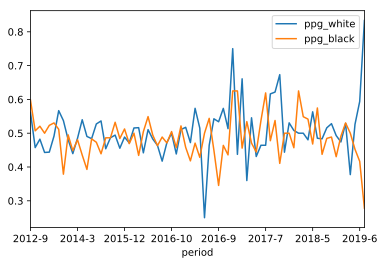

In [149]:
dd.set_index('period')[['ppg_white', 'ppg_black']].plot()

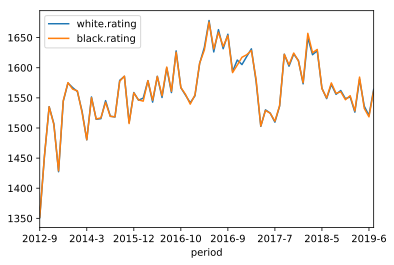

In [150]:
dd.set_index('period')[['white.rating', 'black.rating']].plot()

In [155]:
tm=prep(df, 'Rosolimo', 'time_control')

In [156]:
tm

,time_control,game_white,white.score,white.rating,ppg_white,game_black,black.score,black.rating,ppg_black
0,120+1,3,3.0,1402.333333,1.000000,4,2.0,1393.250000,0.500000
1,180,33,19.5,1397.696970,0.590909,30,20.0,1390.800000,0.666667
2,180+2,1919,974.5,1568.508077,0.507817,1927,947.0,1569.259471,0.491437
3,300,3659,1789.5,1550.330145,0.489068,3646,1752.5,1550.037850,0.480664
4,300+2,6,1.0,1443.833333,0.166667,4,1.5,1411.000000,0.375000
5,300+3,7,1.5,1648.285714,0.214286,7,2.5,1649.000000,0.357143
6,600,92,43.0,1453.739130,0.467391,93,42.0,1455.784946,0.451613


In [165]:
deb=prep(df, 'Rosolimo', 'eco_url').fillna(0)

In [167]:
deb.sort_values(by='game_white', ascending=False)

,eco_url,game_white,white.score,white.rating,ppg_white,game_black,black.score,black.rating,ppg_black
331,https://www.chess.com/openings/D10-Slav-Defense-3.Nc3,435.0,221.5,1556.841379,0.509195,19.0,8.5,1528.421053,0.447368
348,https://www.chess.com/openings/D20-Queens-Gambit-Accepted-Old-Variation,371.0,222.5,1538.153639,0.599730,0.0,0.0,0.000000,0.000000
355,https://www.chess.com/openings/D30-Queens-Gambit-Declined,291.0,142.5,1562.250859,0.489691,0.0,0.0,0.000000,0.000000
377,https://www.chess.com/openings/D31-Queens-Gambit-Declined-Semi-Slav-Defense-Accelerated-Move-Order,144.0,66.0,1555.583333,0.458333,0.0,0.0,0.000000,0.000000
357,https://www.chess.com/openings/D30-Queens-Gambit-Declined-3.Nf3-Nf6,110.0,49.0,1557.181818,0.445455,0.0,0.0,0.000000,0.000000
394,https://www.chess.com/openings/D35-Queens-Gambit-Declined-Queens-Knight-Variation-3...Nf6,110.0,60.0,1551.636364,0.545455,1.0,0.0,1404.000000,0.000000
120,https://www.chess.com/openings/A40-Queens-Pawn-Opening-Horwitz-Defense-2.c4,98.0,45.5,1544.775510,0.464286,2.0,0.0,1492.000000,0.000000
304,https://www.chess.com/openings/D06-Queens-Gambit-Declined-Marshall-Defense,86.0,50.0,1566.732558,0.581395,9.0,3.0,1587.333333,0.333333
109,https://www.chess.com/openings/A40-Modern-Defense-with-1-d4-2.c4-Bg7-3.Nc3,83.0,44.0,1536.265060,0.530120,0.0,0.0,0.000000,0.000000
235,https://www.chess.com/openings/A85-Dutch-Defense-Queens-Knight-Variation,83.0,39.0,1559.409639,0.469880,0.0,0.0,0.000000,0.000000


In [168]:
wreson=prep(df, 'Rosolimo', 'white.result').fillna(0)

In [170]:
wreson.sort_values(by='game_white', ascending=False)

,white.result,game_white,white.score,white.rating,ppg_white,game_black,black.score,black.rating,ppg_black
10,win,2660,2660.0,1558.418045,1.0,2722,0.0,1550.893093,0.0
6,resigned,1771,0.0,1550.909656,0.0,1287,1287.0,1557.968143,1.0
3,checkmated,690,0.0,1543.568116,0.0,372,372.0,1551.758065,1.0
8,timeout,185,0.0,1555.248649,0.0,874,874.0,1557.316934,1.0
4,insufficient,160,80.0,1553.237500,0.5,163,81.5,1549.490798,0.5
5,repetition,96,48.0,1550.635417,0.5,97,48.5,1556.556701,0.5
2,agreed,81,40.5,1558.160494,0.5,91,45.5,1567.208791,0.5
7,stalemate,37,0.0,1557.324324,0.0,40,0.0,1540.625000,0.0
1,abandoned,32,0.0,1547.562500,0.0,53,53.0,1559.037736,1.0
9,timevsinsufficient,6,3.0,1643.000000,0.5,10,5.0,1668.600000,0.5


In [173]:
def elo_prob(rw, rb):
    return 1/(1+np.power(10, (rb-rw)/400))

In [185]:
ch=df.sort_values(by=['date', 'time'])
ch['white_elo_forecast']=ch[['white.rating', 'black.rating']].apply(lambda x: elo_prob(*x), axis=1)
ch['black_elo_forecast']=ch[['black.rating', 'white.rating']].apply(lambda x: elo_prob(*x), axis=1)

In [187]:
ch.to_csv('Rosolimo.csv')

In [186]:
ch[0:30]

,rules,time_class,time_control,rated,result,date,time,white.username,black.username,white.rating,black.rating,white.result,black.result,white.score,black.score,eco,eco_url,game_url,white_url,black_url,game,period,white_elo_forecast,black_elo_forecast
0,chess,blitz,600,True,0-1,2012-09-13,12:04:27,Rosolimo,Hanzalah76,1016,1142,resigned,win,0.0,1.0,D06,https://www.chess.com/openings/D06-Queens-Gambit,https://www.chess.com/live/game/361090385,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/hanzalah76,1,2012-9,0.326224,0.673776
0,chess,blitz,600,True,1-0,2012-09-13,12:14:18,Hanzalah76,Rosolimo,1147,918,win,checkmated,1.0,0.0,B20,https://www.chess.com/openings/B20-Sicilian-Defense-2.d3-Nc6,https://www.chess.com/live/game/361093887,https://api.chess.com/pub/player/hanzalah76,https://api.chess.com/pub/player/rosolimo,1,2012-9,0.788887,0.211113
0,chess,blitz,600,True,1-0,2012-09-13,12:34:24,Rosolimo,Hanzalah76,1085,1134,win,checkmated,1.0,0.0,D20,https://www.chess.com/openings/D20-Queens-Gambit-Accepted-Old-Variation,https://www.chess.com/live/game/361102676,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/hanzalah76,1,2012-9,0.429947,0.570053
0,chess,blitz,600,True,0-1,2012-09-13,12:43:13,Hanzalah76,Rosolimo,1125,1188,resigned,win,0.0,1.0,C02,https://www.chess.com/openings/C02-French-Defense-Advance-Nimzowitsch-System,https://www.chess.com/live/game/361106133,https://api.chess.com/pub/player/hanzalah76,https://api.chess.com/pub/player/rosolimo,1,2012-9,0.410316,0.589684
0,chess,blitz,300,True,0-1,2012-09-13,17:02:42,Rosolimo,1123581321,1108,1184,resigned,win,0.0,1.0,D20,https://www.chess.com/openings/D20-Queens-Gambit-Accepted-Old-Variation,https://www.chess.com/live/game/361229284,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/1123581321,1,2012-9,0.392339,0.607661
0,chess,blitz,300,True,0-1,2012-09-13,17:08:15,1123581321,Rosolimo,1174,1188,resigned,win,0.0,1.0,A45,https://www.chess.com/openings/A45-Indian-Game,https://www.chess.com/live/game/361232031,https://api.chess.com/pub/player/1123581321,https://api.chess.com/pub/player/rosolimo,1,2012-9,0.479863,0.520137
0,chess,blitz,300,True,1-0,2012-09-13,17:15:33,Rosolimo,Narlygang6,1251,1209,win,timeout,1.0,0.0,D06,https://www.chess.com/openings/D06-Queens-Gambit-Declined-Marshall-Defense-3.Nc3,https://www.chess.com/live/game/361235540,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/narlygang6,1,2012-9,0.560150,0.439850
0,chess,blitz,300,True,0-1,2012-09-14,09:21:36,melindbg,Rosolimo,1175,1293,timeout,win,0.0,1.0,D00,https://www.chess.com/openings/D00-Queens-Pawn-Opening-1...d5-2.e3,https://www.chess.com/live/game/361601599,https://api.chess.com/pub/player/melindbg,https://api.chess.com/pub/player/rosolimo,1,2012-9,0.336426,0.663574
0,chess,blitz,300,True,1-0,2012-09-14,13:48:53,chaman81,Rosolimo,1206,1234,win,resigned,1.0,0.0,C11,https://www.chess.com/openings/C11-French-Defense-Classical-Burn-Variation-5.Nxe4,https://www.chess.com/live/game/361707022,https://api.chess.com/pub/player/chaman81,https://api.chess.com/pub/player/rosolimo,1,2012-9,0.459792,0.540208
0,chess,blitz,180,True,1-0,2012-09-14,14:01:46,Rosolimo,markitos1111,1266,1138,win,checkmated,1.0,0.0,A40,https://www.chess.com/openings/A40-Modern-Defense-with-1-d4-2.c4-Bg7-3.Nc3,https://www.chess.com/live/game/361712768,https://api.chess.com/pub/player/rosolimo,https://api.chess.com/pub/player/markitos1111,1,2012-9,0.676302,0.323698
